In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os

In [2]:
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToTensor, PILToTensor, Resize, Compose, ToImage,ToPILImage
from torchvision.models import resnet50, ResNet50_Weights


In [3]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()


transform = Compose([
    ToPILImage(mode="RGB"),
    transforms.v2.Lambda(lambda img: img.convert("RGB")),  # Ensure the image is in RGB mode
    ToTensor(),
    preprocess
])
print(preprocess)
dataset = datasets.Caltech101(root="./data",download=True,transform=transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Files already downloaded and verified


/home/timo/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Training data: {len(train_dataset)}. Test data: {len(test_dataset)}")

Training data: 6941. Test data: 1736


In [5]:
batch_size = 64

train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [7]:
model = resnet50(weights=weights) # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
model.fc = nn.Linear(2048,101)
model = model.to(device)

In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
# Load model from file if it exists, otherwise train
if os.path.isfile("model_weights.pth"):
    model = resnet50(weights=weights)
    model.fc = nn.Linear(2048,101)
    
    model.load_state_dict(torch.load("model_weights.pth"))
    model = model.to(device)
    model.eval()
    test(test_dataloader, model, loss_fn)
else:
    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
    print("Done!")
    torch.save(model.state_dict(), "model_weights.pth")

/tmp/ipykernel_67203/393794167.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


Test Error: 
 Accuracy: 98.6%, Avg loss: 0.096336 



In [13]:
def show_image(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    
    # Apply the unnormalize transform
    unnormalized_img = unnormalize(image)
    # Convert the tensor to a NumPy array for display
    unnormalized_img = unnormalized_img.permute(1, 2, 0).numpy()
    
    # Clip values to be in the range [0, 1]
    unnormalized_img = np.clip(unnormalized_img, 0, 1)
    
    # Display the image
    #plt.imshow(unnormalized_img)
    display(ToPILImage()(unnormalized_img))

In [14]:
# Read text labels from file
with open("labels.txt") as infile:
    labels = infile.readlines()
    labels = [x.strip() for x in labels]

In [15]:
def get_representative_images(dataset):
    # Returns one image per label
    images = [None] * 101
    
    for image,label in dataset:
        if images[label] == None:
            images[label] = image
            print(label)
    return images

# Adversarial Learning

In [16]:
print(labels[16])
print(labels[81])

butterfly
scorpion


In [17]:
import random

In [18]:
correct_label = 81


In [19]:
def getImage(dataset,target_label):
    if type(target_label) == str:
        target_label = labels.index(target_label)
        
    images = []
    for image,label in dataset:
        if label == target_label:
            images.append(image)
        
    return random.choice(images)

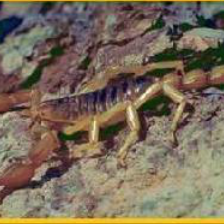

In [20]:
original_image = getImage(dataset,correct_label)
show_image(original_image)

In [21]:
X = original_image.unsqueeze(0).to(device)

pred = pred = model(X)
print("Prediction:",labels[pred.argmax(1)])
print(f"Confidence : \n{labels[correct_label]}:",nn.Softmax(dim=1)(pred)[0,correct_label].item())



Prediction: scorpion
Confidence : 
scorpion: 0.9434404373168945


## Untargeted Attack

In [22]:
def generate_adversarial_image_untargeted(input_image,model,correct_label):
    
    X = input_image.unsqueeze(0).to(device)
    y = torch.tensor(correct_label).unsqueeze(0).to(device)
    X, y = X.to(device), y.to(device)
    perturbation = torch.rand(X.shape,requires_grad=True,device=device)
    optimizer = torch.optim.SGD([perturbation], lr=0.1)
    
    loss_fn = nn.CrossEntropyLoss()
    epsilon = 2./255
    model.eval()
    
    for i in range(20):
        adversarial_input = X+perturbation
        adversarial_input = torch.clamp(adversarial_input, 0, 1)

        pred = model(adversarial_input)
        loss = -loss_fn(pred, y)
        loss.backward()
    
        optimizer.step()
        with torch.no_grad():
            perturbation.clamp_(-epsilon, epsilon)
        optimizer.zero_grad()
    image_tensor = (X+perturbation)[0].clamp_(0,1)
    return image_tensor.detach(),perturbation

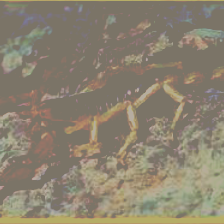

In [23]:
adversarial_image,perturbation = generate_adversarial_image_untargeted(original_image,model,correct_label)
show_image(adversarial_image.cpu())

In [24]:
X = adversarial_image.unsqueeze(0).to(device)
pred = model(X)
print("Prediction:",labels[pred.argmax(1)])
print(f"Confidence : \n{labels[correct_label]}:",nn.Softmax(dim=1)(pred)[0,correct_label].item())
print(f"{labels[pred.argmax(1)]}:",nn.Softmax(dim=1)(pred)[0,pred.argmax(1)].item())



Prediction: crab
Confidence : 
scorpion: 0.0005711345584131777
crab: 0.9735129475593567


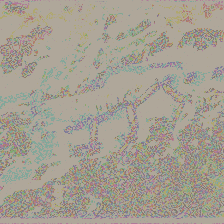

In [25]:
show_image((50*perturbation+0.5)[0].detach().cpu())

## Targeted Attack

In [26]:
target_label = 16
print(labels[target_label])

butterfly


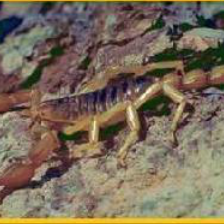

Confidence : 
scorpion: 0.9434404373168945
butterfly: 0.0003175771562382579
scorpion


In [35]:
X = original_image.unsqueeze(0).to(device)
show_image(original_image)
pred = pred = model(X)
print(f"Confidence : \n{labels[correct_label]}:",nn.Softmax(dim=1)(pred)[0,correct_label].item())
print(f"{labels[target_label]}:",nn.Softmax(dim=1)(pred)[0,target_label].item())

print(labels[pred.argmax(1)])

In [28]:
def generate_adversarial_image_targeted(input_image,model,correct_label):
    
    X = input_image.unsqueeze(0).to(device)
    y = torch.tensor(correct_label).unsqueeze(0).to(device)
    X, y = X.to(device), y.to(device)
    perturbation = torch.zeros(X.shape,requires_grad=True,device=device)
    optimizer = torch.optim.SGD([perturbation], lr=0.1)
    
    loss_fn = nn.CrossEntropyLoss()
    epsilon = 2./255
    model.eval()
    
    for i in range(20):
        adversarial_input = X+perturbation
        adversarial_input = torch.clamp(adversarial_input, 0, 1)

        pred = model(adversarial_input)
        loss = loss_fn(pred, y)
        loss.backward()
    
        optimizer.step()
        with torch.no_grad():
            perturbation.clamp_(-epsilon, epsilon)
        optimizer.zero_grad()
    image_tensor = (X+perturbation)[0].clamp_(0,1)
    return image_tensor.detach(),perturbation

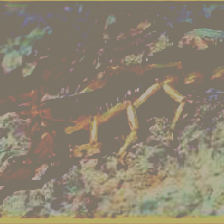

In [29]:
adversarial_image,perturbation = generate_adversarial_image_targeted(original_image,model,target_label)
show_image(adversarial_image.cpu())

In [30]:
X = adversarial_image.unsqueeze(0).to(device)
pred = model(X)
print("Prediction:",labels[pred.argmax(1)])
print(f"Confidence : \n{labels[correct_label]}:",nn.Softmax(dim=1)(pred)[0,correct_label].item())
print(f"{labels[target_label]}:",nn.Softmax(dim=1)(pred)[0,target_label].item())


Prediction: butterfly
Confidence : 
scorpion: 0.002059296704828739
butterfly: 0.9592039585113525


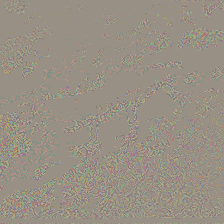

In [31]:
show_image((50*perturbation+0.5)[0].detach().cpu())

## Fast Gradient Sign Method

In [32]:
def fastGradientSignMethod(input_image, target_label, model,epsilon):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    X = input_image.unsqueeze(0).to(device)
    y = torch.tensor(target_label).unsqueeze(0).to(device)

    perturbation = torch.zeros(X.shape,requires_grad=True,device=device)
    adversarial_input = X+perturbation
    pred = model(adversarial_input)
    print(f"Confidence original image: {pred[0][target_label].item()}")
    loss = -loss_fn(pred, y)
    loss.backward()
    with torch.no_grad():
        perturbation = epsilon * perturbation.grad.sign()
        adversarial_input = X + perturbation
    #print(perturbation)
    return adversarial_input.clamp_(0,1).cpu(), perturbation

Confidence original image: 3.448331117630005


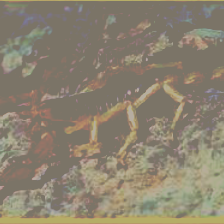

Prediction: scorpion
Confidence : 
scorpion: 0.6416321992874146
scorpion: 0.6416321992874146


In [33]:
adversarial_image, perturbation = fastGradientSignMethod(original_image,correct_label,model,0.001)
show_image(adversarial_image[0])
X = adversarial_image.to(device)
pred = model(X)
print("Prediction:",labels[pred.argmax(1)])
print(f"Confidence : \n{labels[correct_label]}:",nn.Softmax(dim=1)(pred)[0,correct_label].item())
print(f"{labels[pred.argmax(1)]}:",nn.Softmax(dim=1)(pred)[0,pred.argmax(1)].item())

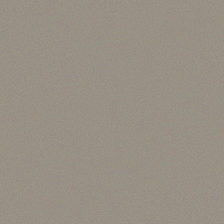

In [34]:
show_image((50*perturbation+0.5)[0].detach().cpu())